# Mitigating Algorithmic Bias

This chapter demonstrates a few representative algorithms for mitigating algorithmic bias. As discussed in the Chapter {doc}`1-1-intro`, algorithmic bias can arise from (i) pre-existing bias in data, (ii) bias introduced during model training, and (iii) bias introduced when making predictions / decisions. Accordingly, to mitigate these biases, there are at least three types of approaches:

- **Pre-processing Approaches**: pre-process training data to remove existing bias, before training models;
- **In-processing Approaches**: modify how models are trained to impose fairness as a learning objective or constraint;
- **Post-processing Approaches**: post-process model outputs (e.g., predictions or predicted probabilities) to satisfy certain fairness objective.

We will use the [LSAC Bar Passage Data](https://eric.ed.gov/?id=ED469370) for illustration. This data, originally collected by {cite:t}`wightman1998lsac`, contains the bar passage outcomes and demographic information of over 20,000 individuals.

```{admonition} Data: Compas Recidivism Dataset
:class: note
- Location: "data/bar_pass_prediction.csv"
- Shape: (22407, 5)
- Note: original dataset has a few more columns. They have been removed for cleaner demonstration.
```

We will use ```pass_bar``` as the outcome variable of interest, and treat ```race``` as the sensitive feature. We will focus only on white and black races, and remove any rows with missing data.

In [1]:
import pandas as pd
bar = pd.read_csv('../data/bar_pass_prediction.csv')
bar = bar[bar['race'].isin(['white', 'black'])]
bar.dropna(inplace = True)
bar.reset_index(drop = True, inplace = True)
bar.head()

,lsat,ugpa,gender,race,pass_bar
0,44.0,3.5,female,white,1
1,29.0,3.5,female,white,1
2,36.0,3.5,male,white,1
3,39.0,3.5,male,white,1
4,48.0,3.5,male,white,1


In [2]:
# we will use lsat, upga, gender, and race as the features
X = bar[['lsat', 'ugpa', 'gender', 'race']]
Y = bar['pass_bar']
# many ML algorithms take numerical input, so let's convert the categorical variables to numerical
X = pd.get_dummies(X, columns = ['gender', 'race'], drop_first = True, dtype=int)
X.columns

Index(['lsat', 'ugpa', 'gender_male', 'race_white'], dtype='object')

In [31]:
# Let's first build a baseline classifier for demonstration
# using random forest here, please feel free to try other techniques
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# we will use 70% of the data for training and 30% for testing
# setting random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

# train the random forest classifier
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf.fit(X_train, y_train)

# make predictions on the testing data
y_pred = rf_clf.predict(X_test)

In [30]:
# Throughout this chapter, we will evaluate multiple models in terms of both predictive performance and fairness
# For predictive performance: we will report the accuracy, precision, recall, and F1 score
# For fairness: we will report demographic disparity and equalized odds disparity
# let's create a function so that we don't need to repeat the same code multiple times
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from fairlearn import metrics
def evaluate_model(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, pos_label = 1, average = 'binary')
    DD = metrics.demographic_parity_difference(y_test, y_pred, sensitive_features = X_test['race_white'])
    EOD = metrics.equalized_odds_difference(y_test, y_pred, sensitive_features = X_test['race_white'])
    # print all metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    print('Demographic Disparity:', DD)
    print('Equalized Odds Disparity:', EOD)

In [32]:
# evaluate model
evaluate_model(y_test, y_pred)

Accuracy: 0.844939338540801
Precision: 0.9557034220532319
Recall: 0.8777719573947966
F1 Score: 0.915081459907163
Demographic Disparity: 0.16762272165217595
Equalized Odds Disparity: 0.21173469387755106


## Pre-Processing Approaches

### Naive Approach: Remove Sensitive Feature

The idea of pre-processing is to modify the data used for model training to remove the existing bias. Perhaps a seemingly obvious pre-processing approach is to simply drop the sensitive group attribute (```race``` in this case). After all, if the model is "blind" to race, it cannot have racial bias, right? Well, let's try it out.

In [33]:
# now build another classifier without the race column
X_norace_train = X_train.drop(columns = ['race_white'])
X_norace_test = X_test.drop(columns = ['race_white'])
# train the random forest classifier
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf.fit(X_norace_train, y_train)
# make predictions on the testing data
y_pred_norace = rf_clf.predict(X_norace_test)
# evaluate the model
evaluate_model(y_test, y_pred_norace)

Accuracy: 0.8311450889147416
Precision: 0.9567578049253442
Recall: 0.8615330888772481
F1 Score: 0.9066519661889011
Demographic Disparity: 0.21030078689322695
Equalized Odds Disparity: 0.21967584303597842


We can see that, both demographic disparity and equalized odds disparity actually become greater. In general, removing sensitive feature from data has limited effectiveness. This is because other legitimate features in the data can be correlated with the sensitive feature. Indeed, as shown below, LSAT score and undergraduate GPA are both correlated with race to some degree.

In [34]:
X.corrwith(X['race_white'])

lsat           0.376971
ugpa           0.222320
gender_male    0.099201
race_white     1.000000
dtype: float64

```{warning}
One could argue that the correlations between LSAT score / undergraduate GPA with race are themselves manifestations of existing racial bias in the education systme (e.g., perhaps black students systematically received less support in schools, leading to lower LSAT scores and undergraduate GPAs). In generally, what counts as "legitimate" or "non-sensitive" features can be a point of debate. 
```

### Correlation Remover

To deal with this issue, we need to systematically remove the correlations between each non-sensitive feature and the sensitive feature. This can be done via the ```CorrelationRemover``` function in the ```fairlearn``` package. Under the hood, it removes correlations by running linear regressions of non-sensitive features on the sensitive feature and obtaining the residuals.

In [35]:
from fairlearn.preprocessing import CorrelationRemover
cr = CorrelationRemover(sensitive_feature_ids=["race_white"])
X_cr_train = cr.fit_transform(X_train)
# transformation returns a numpy array, let's convert it back to a pandas dataframe
X_cr_train = pd.DataFrame(X_cr_train, columns = ['lsat', 'ugpa', 'gender_male'])
# check correlations again - they are very close to 0 now
race_train = X_train['race_white']
race_train.reset_index(drop = True, inplace = True)
X_cr_train.corrwith(race_train)

lsat           2.069709e-14
ugpa           1.209489e-14
gender_male    5.147216e-15
dtype: float64

In [36]:
# now build another classifier with the transformed data
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
rf_clf.fit(X_cr_train, y_train)
# make predictions on the testing data
y_pred_cr = rf_clf.predict(X_norace_test)
# evaluate the model
evaluate_model(y_test, y_pred_cr)

Accuracy: 0.9017782948313113
Precision: 0.9548352816153028
Recall: 0.9413305395495024
F1 Score: 0.9480348193088894
Demographic Disparity: 0.061266896331535925
Equalized Odds Disparity: 0.07971938775510201


We can see that both disparities are further reduced, especially disparity in terms of equalized odds.

## In-Processing Approaches

Compared to data pre-processing, in-processing approaches aim to mitigate bias by modifying how the model is trained. Many modern machine learning models are trained as an _optimization problem_, i.e., by minimizing a certain loss function (computed over training data). Therefore, some natural ways to mitigate bias include (1) modifying the objective function to have fairness as a part, such as fair regularization approaches ({cite:t}`kamishima2011fairness`); and (2) add fairness as constraints in the optimization problem ({cite:t}`zafar2017fairnessconstraints,cotter2018training,komiyama2018nonconvex,celis2019classification`).

## Post-Processing Approaches

Finally, post-processing approaches mitigate bias by changing how a model's predictions are used. For binary classification, one of the most common approaches here is to adjust the prediction threshold ({cite:t}`hardt2016equality`).

In [37]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
# initialize the threshold optimizer
# "constraint" specifies what kind of fairness goal you want to achieve
# "objective" specifies the learning objective
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
TO_demo = ThresholdOptimizer(estimator = rf_clf, constraints = 'demographic_parity', objective = "accuracy_score", predict_method = 'auto')
TO_demo.fit(X_train, y_train, sensitive_features = X_train['race_white'])
y_pred_to = TO_demo.predict(X_test, sensitive_features = X_test['race_white'], random_state = 42)
evaluate_model(y_test, y_pred_to)

Accuracy: 0.9511384410835965
Precision: 0.951921477291632
Recall: 0.99912694255282
F1 Score: 0.9749531436360538
Demographic Disparity: 0.001068947087119243
Equalized Odds Disparity: 0.00520833333333337


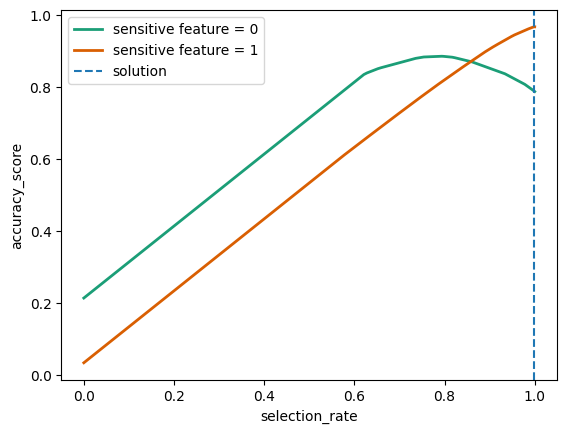

In [38]:
plot_threshold_optimizer(TO_demo)

In [39]:
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = 'balanced')
TO_EqualOdds = ThresholdOptimizer(estimator = rf_clf, constraints = 'equalized_odds', objective = "accuracy_score", predict_method = 'auto')
TO_EqualOdds.fit(X_train, y_train, sensitive_features = X_train['race_white'])
y_pred_to = TO_EqualOdds.predict(X_test, sensitive_features = X_test['race_white'], random_state = 42)
evaluate_model(y_test, y_pred_to)

Accuracy: 0.9511384410835965
Precision: 0.951921477291632
Recall: 0.99912694255282
F1 Score: 0.9749531436360538
Demographic Disparity: 0.001068947087119243
Equalized Odds Disparity: 0.00520833333333337


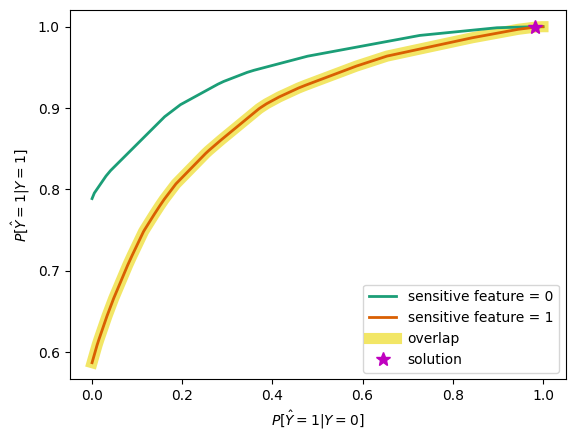

In [40]:
plot_threshold_optimizer(TO_EqualOdds)